# <div style="color:white;display:fill;border-radius:5px;background-color:#f55a42;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:white;overflow:hidden;margin:0;font-size:110%"><b></b> Adversarial Attacks</p></div>

> #### My research interest is on Machine Learning Security and today I want to share you how some adversarial attacks works! Hope you will enjoy and get important information. 

> * Many of us try to create models to classify images. On the other side, there are some guys are trying to decieve the models with adversarial examples. 😉 

### What is an adversarial example? 
> Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These notorious inputs are indistinguishable to the human eye, but cause the network to fail to identify the contents of the image. There are several types of such attacks, however, here the focus is on the fast gradient sign method attack, which is a white box attack whose goal is to ensure misclassification. A white box attack is where the attacker has complete access to the model being attacked. 

<img src='https://raw.githubusercontent.com/fukashi-hatake/kaggle_notebooks/main/images/adversarial_example.png'> 

> You can also learn more about attacks on Tensorflow post [here](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm). 

> #### Today, I will use toolbox that contains the implementations of adversarial attacks. it is toolbox ART: https://adversarial-robustness-toolbox.readthedocs.io/ 

> * In this toolbox you can find implementation of many attacks and defenses. 

> * Demo: https://art-demo.mybluemix.net/ 

### <font color='#f55a42'> Let's get into it! </font> 


In [1]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.2 MB 2.8 MB/s            


In [2]:
import time 
import numpy as np 
import torch.nn as nn 
from datetime import datetime

from PIL import Image
from torchvision import transforms
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt 

from art.estimators.classification import PyTorchClassifier
from skimage.metrics import structural_similarity as ssim 

import warnings
warnings.filterwarnings('ignore') 

In [3]:
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import FastGradientMethod

In [4]:
def softmax_activation(inputs): 
    inputs = inputs.tolist()
    exp_values = np.exp(inputs - np.max(inputs)) 
    
    # Normalize 
    probabilities = exp_values / np.sum(exp_values)
    return probabilities 

### <font color='#f55a42'> Calculating noise </font> 
> Using SSIM (Structural Similarity Index), we can compare the real image (=benign) and fake image (=adversarial). 

In [5]:
def compare_images(imageA, imageB):
    return 1 - ssim(imageA, imageB, multichannel=True) 

In [6]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
]) 

#### <font color='#f55a42'> Loading the pre-trained model on ImageNet from PyTorch </font>

In [7]:
model_resnet18 = models.resnet18(pretrained=True)  

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [8]:
criterion = nn.CrossEntropyLoss()

# Create the ART classifier

classifier = PyTorchClassifier(
    model=model_resnet18,
    loss=criterion,
    input_shape=(3, 224, 224),
    nb_classes=1000,
    device_type='gpu'
)

### <font color='#f55a42'> Loading Image </font>
> We selected image of panda, you can choose any other image on Imagenet classes range. 

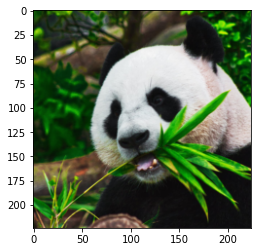

In [9]:
import requests 
url = "https://raw.githubusercontent.com/fukashi-hatake/kaggle_notebooks/main/images/giant_panda.jpg"
input_image = Image.open(requests.get(url, stream=True).raw)

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).numpy().astype(np.float32)

input = input_batch[0].transpose((1,2,0))
plt.imshow(input)

In [10]:
preds = classifier.predict(input_batch)
print(np.argmax(preds, axis=1))

accuracy = np.max(softmax_activation(preds), axis=1)
accuracy = round(accuracy[0], 2)
print("Accuracy on benign examples: {}%".format(accuracy * 100)) 

[388]
Accuracy on benign examples: 70.0%


> #### 388 label is "giant panda" on ImageNet, and you can see that resnet 18 model is classifiying the given image correctly with 70% confidence.  

### <font color='#f55a42'> 1 | FGSM Attack 

In [11]:
fgsm_attack = FastGradientMethod(estimator = classifier, eps=0.05) 

start = time.time()
x_test_adv = fgsm_attack.generate(x=input_batch)
print("Time for attack (in seconds): {}".format(time.time()-start))  

Time for attack (in seconds): 0.44657135009765625


> It is quite fast attack, because it takes only one iteration to find the noise. You can read more about this attack on following paper [here](https://arxiv.org/pdf/1412.6572.pdf). 

In [12]:
predictions = classifier.predict(x_test_adv)
print(np.argmax(predictions, axis=1))

accuracy = round(np.max(softmax_activation(predictions), axis=1)[0]*100,2)
print("Accuracy on adversarial test examples: {}%".format(accuracy))

[47]
Accuracy on adversarial test examples: 29.64%


> #### FGSM attack successfully decived the model, after adding noise to the image, the model classifying the panda as label 47 (African chameleon). 

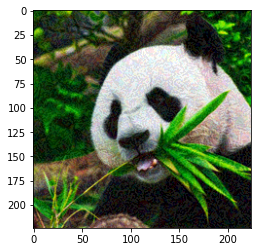

In [13]:
input = x_test_adv[0].transpose((1,2,0))
plt.imshow(input)

In [14]:
noise = compare_images(input_batch[0].transpose(1,2,0), x_test_adv[0].transpose(1,2,0))
print("Amount of noise: {}".format(noise))

Amount of noise: 0.2342844009399414


> #### However, you can see that the amount of noise is so much: 0.23 (means 23% of the image is noise)

### <font color='#f55a42'> 2 | PGD Attack  </font>

> Now let's move on more advanced attack, FGSM is the simplest white box attack. now we will try PGD attack. 

In [15]:
pgd_attack = ProjectedGradientDescent(classifier, max_iter=20, eps_step=1, eps=0.01) 

start = time.time()
x_test_adv = pgd_attack.generate(x=input_batch)
print("Time for attack (in seconds): {}".format(time.time()-start))  

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Time for attack (in seconds): 3.9854090213775635


In [16]:
predictions = classifier.predict(x_test_adv)
print(np.argmax(predictions, axis=1))

accuracy = round(np.max(softmax_activation(predictions), axis=1)[0]*100,2)
print("Accuracy on adversarial test examples: {}%".format(accuracy))

[16]
Accuracy on adversarial test examples: 86.84%


> #### Now we can see PGD attack decieves model to class 16 ('bulbul') with very high confidence (89.9%)! 

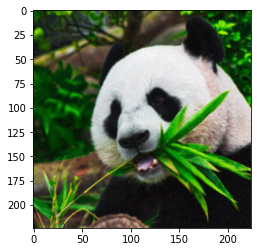

In [17]:
input = x_test_adv[0].transpose((1,2,0))
plt.imshow(input)

> #### As a compared to adversarial image by FGSM, the adversarial image by PGD is more clear (difficult to percieve it). 

In [18]:
noise = compare_images(input_batch[0].transpose(1,2,0), x_test_adv[0].transpose(1,2,0))
print("Amount of noise: {}".format(noise))

Amount of noise: 0.01356285810470581


> #### Wow! amount of noise is just 1% and PGD misclassify the model with very high confidence. From this example you can see the PGD is more efficient than FGSM. The reason is PGD spends some time to find best amount of noise to decieve the model and it does many iteration to test its adversarial image. 

## <font color='#f55a42'>  Thank You for reading  </font>
    
--- 
**if like == True: 
    click(upvote)
else: 
    pass**
---